Лабораторная работа 1.

Выполнил: Очередько А.Н.

Группа: ББМО-01-23

 Скопирован проект по ссылке в локальную среду выполнения Jupyter (Google Colab)

In [5]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project


Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 36.15 MiB/s, done.
Resolving deltas: 100% (27/27), done.


Смена директории

In [6]:
%cd EEL6812_DeepFool_Project


/content/EEL6812_DeepFool_Project/EEL6812_DeepFool_Project


Импорт библиотек

In [7]:
import numpy as np
import json
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms

# Импорт из локальных файлов проекта
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack


Установка случайного рандомного значения.

Установка указанного значения для np.random.seed и torch.manual_seed

In [8]:
# Установите значение в виде порядкового номера
rand_seed = 123


In [9]:
# Установить заданное значение
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")


Используемое устройство: cuda


Загрузка датасета MNIST c параметрами mnist_mean = 0.5, mnist_std = 0.5, mnist_dim = 28

In [11]:
from utils.project_utils import get_clip_bounds

# Параметры датасета MNIST
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

# Получить границы для нормализации
mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

# Трансформации данных
from torchvision.transforms import transforms

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(mean=0.0, std=np.divide(1.0, mnist_std)),
    transforms.Normalize(mean=np.multiply(-1.0, mnist_std), std=1.0)
])

# Загрузка датасета MNIST
from torchvision import datasets
from torch.utils.data import random_split

mnist_temp = datasets.MNIST(
    root='datasets/mnist',
    train=True,
    download=True,
    transform=mnist_tf_train
)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(
    root='datasets/mnist',
    train=False,
    download=True,
    transform=mnist_tf
)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 60.6MB/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.20MB/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.62MB/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



Загрузка датасета CIFAR-10 c параметрами cifar_mean = [0.491, 0.482, 0.447] cifar_std = [0.202, 0.199, 0.201] cifar_dim = 32

In [12]:
# Параметры датасета CIFAR-10
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

# Получить границы для нормализации
cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

# Трансформации данных
cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(size=cifar_dim, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)),
    transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])
])

# Загрузка датасета CIFAR-10
cifar_temp = datasets.CIFAR10(
    root='datasets/cifar-10',
    train=True,
    download=True,
    transform=cifar_tf_train
)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(
    root='datasets/cifar-10',
    train=False,
    download=True,
    transform=cifar_tf
)

# Классы CIFAR-10
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


Выполнена настройка и загрузка DataLoader batch_size = 64 workers = 4

In [13]:
from torch.utils.data import DataLoader

# Параметры DataLoader
batch_size = 64
workers = 4

# DataLoader для MNIST
mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)

# DataLoader для CIFAR-10
cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Загрузка и оценка стойкости модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10

In [14]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))

# Оценка атаки FGSM
evaluate_attack(
    'cifar_nin_fgsm.csv',
    'results',
    device,
    model,
    cifar_loader_test,
    cifar_min,
    cifar_max,
    fgsm_eps,
    is_fgsm=True
)
print('')

# Оценка атаки DeepFool
deep_args = None  # Убедитесь, что аргументы для DeepFool корректно инициализированы
evaluate_attack(
    'cifar_nin_deepfool.csv',
    'results',
    device,
    model,
    cifar_loader_test,
    cifar_min,
    cifar_max,
    deep_args,
    is_fgsm=False
)

if device.type == 'cuda':
    torch.cuda.empty_cache()


FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


<ipython-input-14-1043a80c4b43>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('c

Загрузка и оценка стойкости модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10

In [15]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))

# Оценка атаки FGSM
evaluate_attack(
    'cifar_lenet_fgsm.csv',
    'results',
    device,
    model,
    cifar_loader_test,
    cifar_min,
    cifar_max,
    fgsm_eps,
    is_fgsm=True
)
print('')

# Оценка атаки DeepFool
evaluate_attack(
    'cifar_lenet_deepfool.csv',
    'results',
    device,
    model,
    cifar_loader_test,
    cifar_min,
    cifar_max,
    deep_args,
    is_fgsm=False
)

if device.type == 'cuda':
    torch.cuda.empty_cache()


FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


<ipython-input-15-e2743be88c27>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device(

Выполнена оценка атакующих примеров для сетей

<ipython-input-19-cff2ca693160>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))


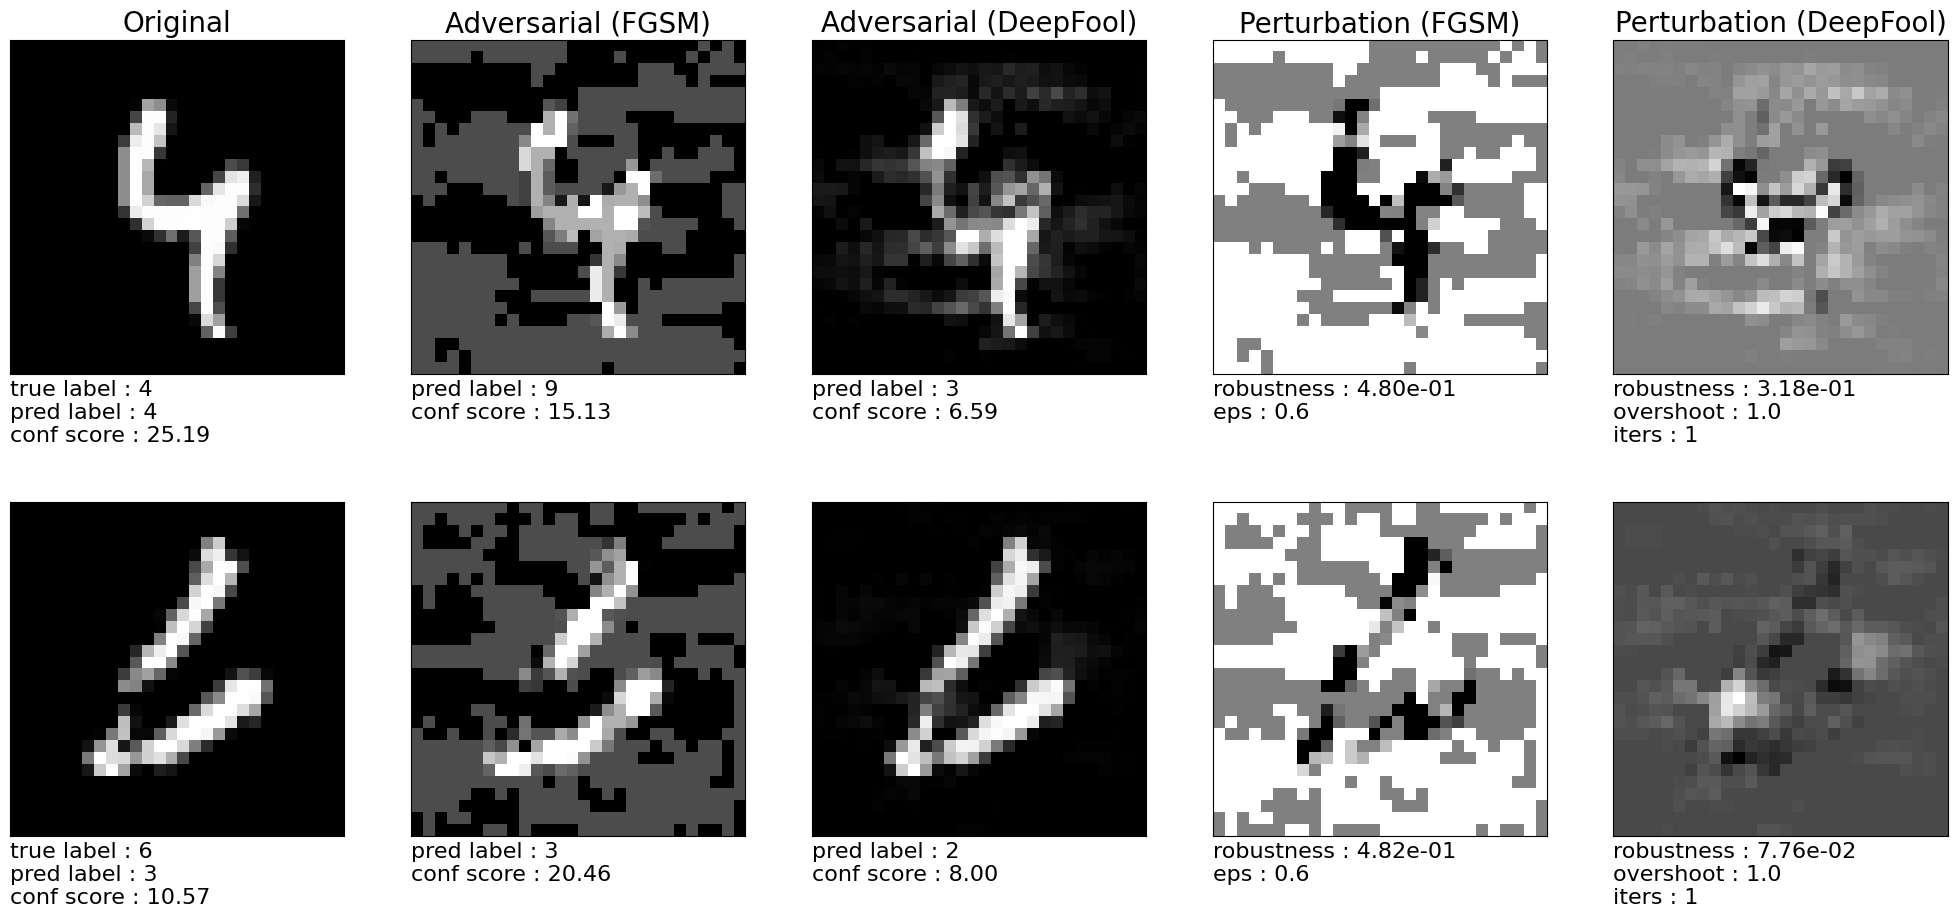

In [19]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

deep_args = [10, 0.02, 1.0, 50]  # Пример конфигурации DeepFool

display_attack(
    device=device,
    model=model,
    test_dataset=mnist_test,
    inv_tf=mnist_tf_inv,
    clip_min=mnist_min,
    clip_max=mnist_max,
    fgsm_eps=fgsm_eps,
    deep_args=deep_args,  # Передаем параметры DeepFool
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11
)

if device.type == 'cuda':
    torch.cuda.empty_cache()


<ipython-input-20-f0111caed238>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


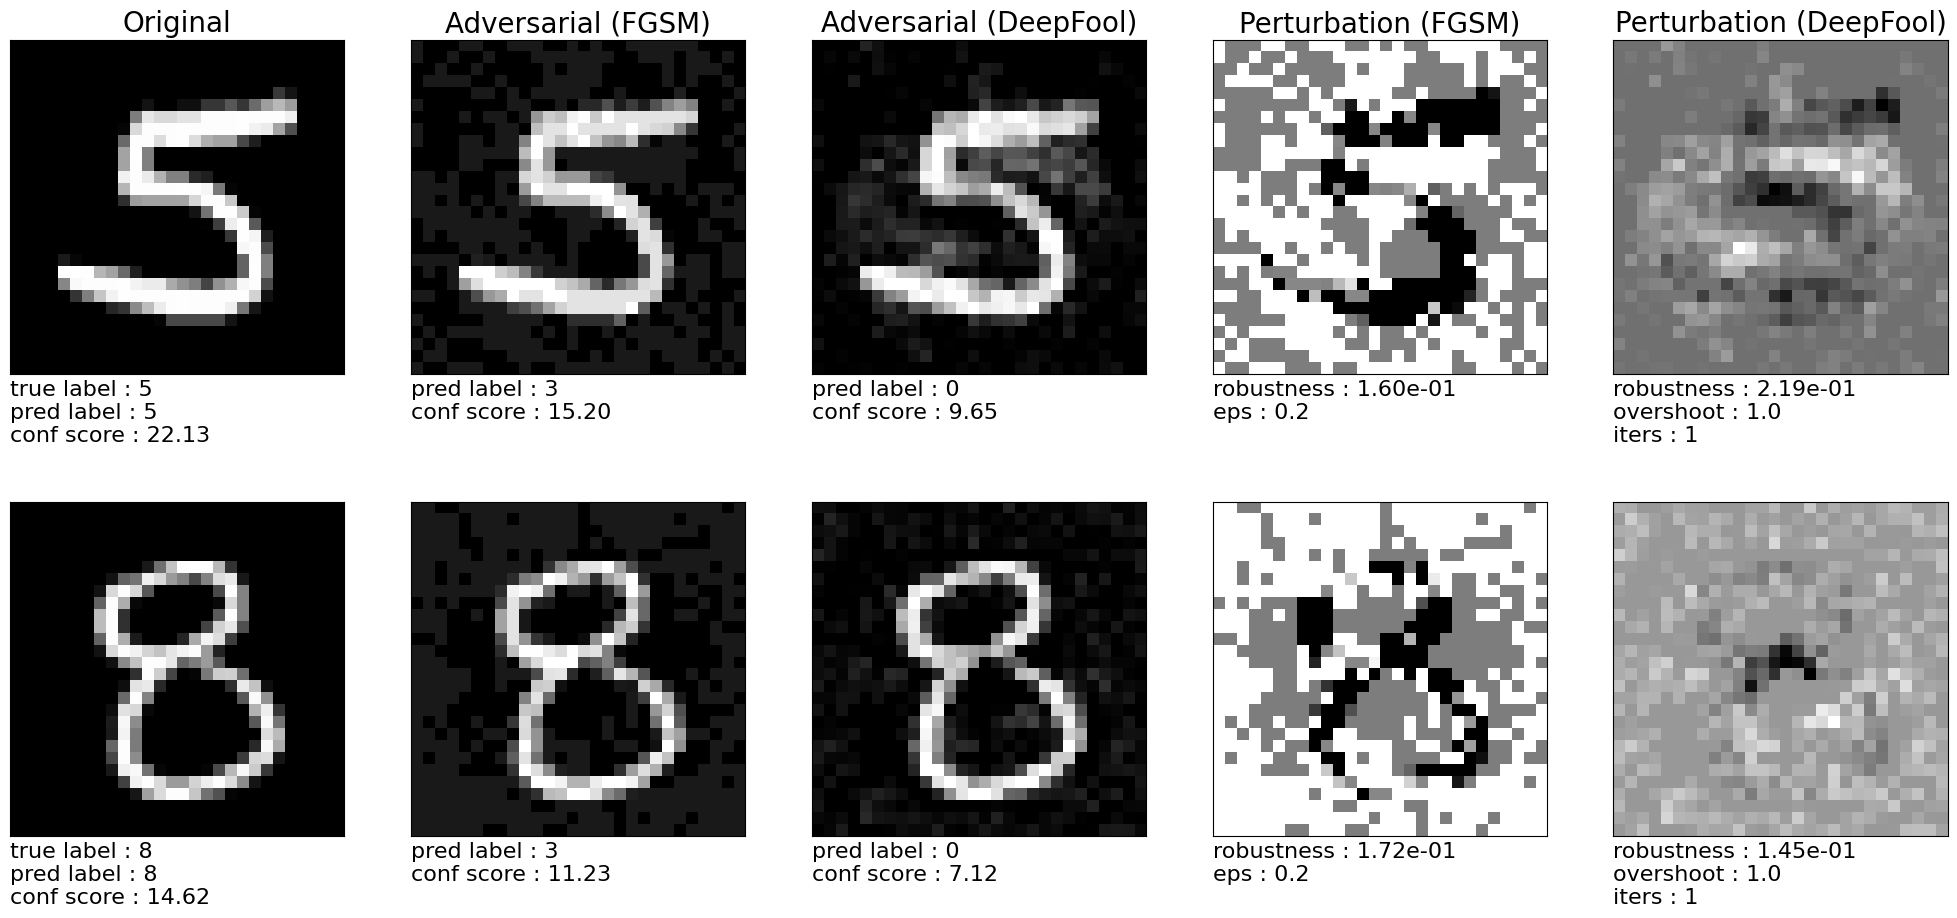

In [20]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(
    device,
    model,
    mnist_test,
    mnist_tf_inv,
    mnist_min,
    mnist_max,
    fgsm_eps,
    deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11
)

if device.type == 'cuda':
    torch.cuda.empty_cache()


<ipython-input-21-dd131c0595a1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


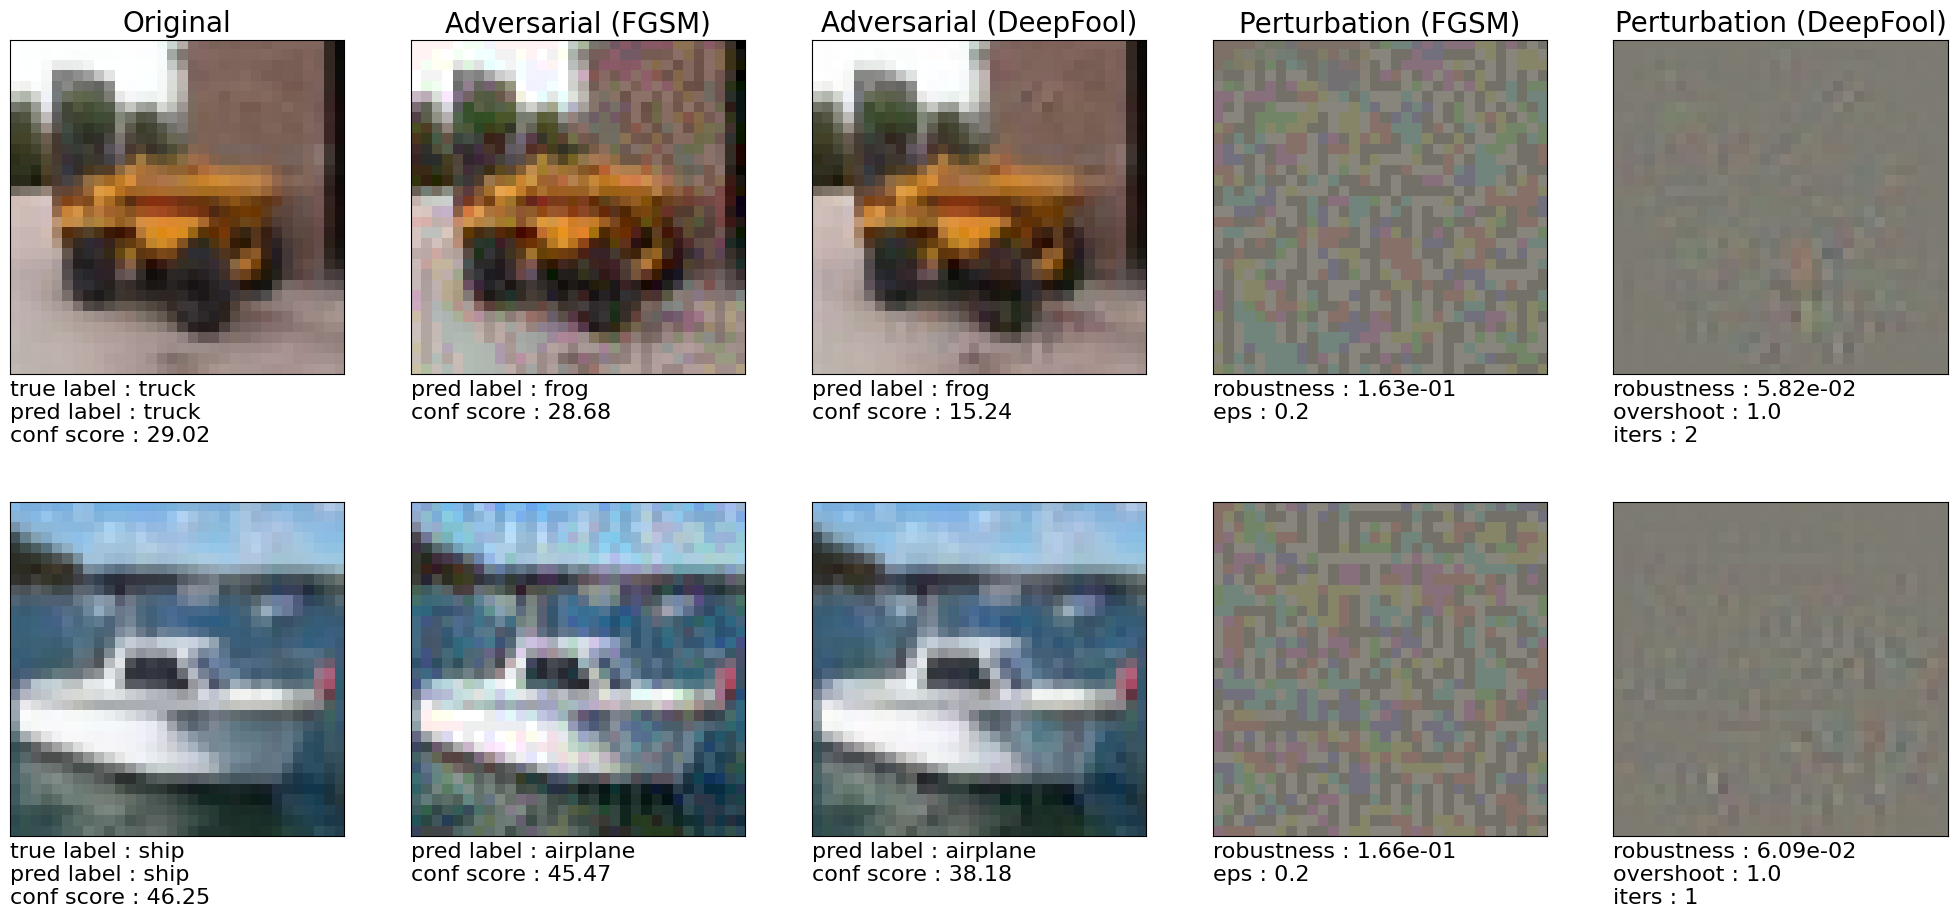

In [21]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(
    device,
    model,
    cifar_test,
    cifar_tf_inv,
    cifar_min,
    cifar_max,
    fgsm_eps,
    deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11,
    label_map=cifar_classes
)

if device.type == 'cuda':
    torch.cuda.empty_cache()


<ipython-input-22-e9a7d2297c29>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


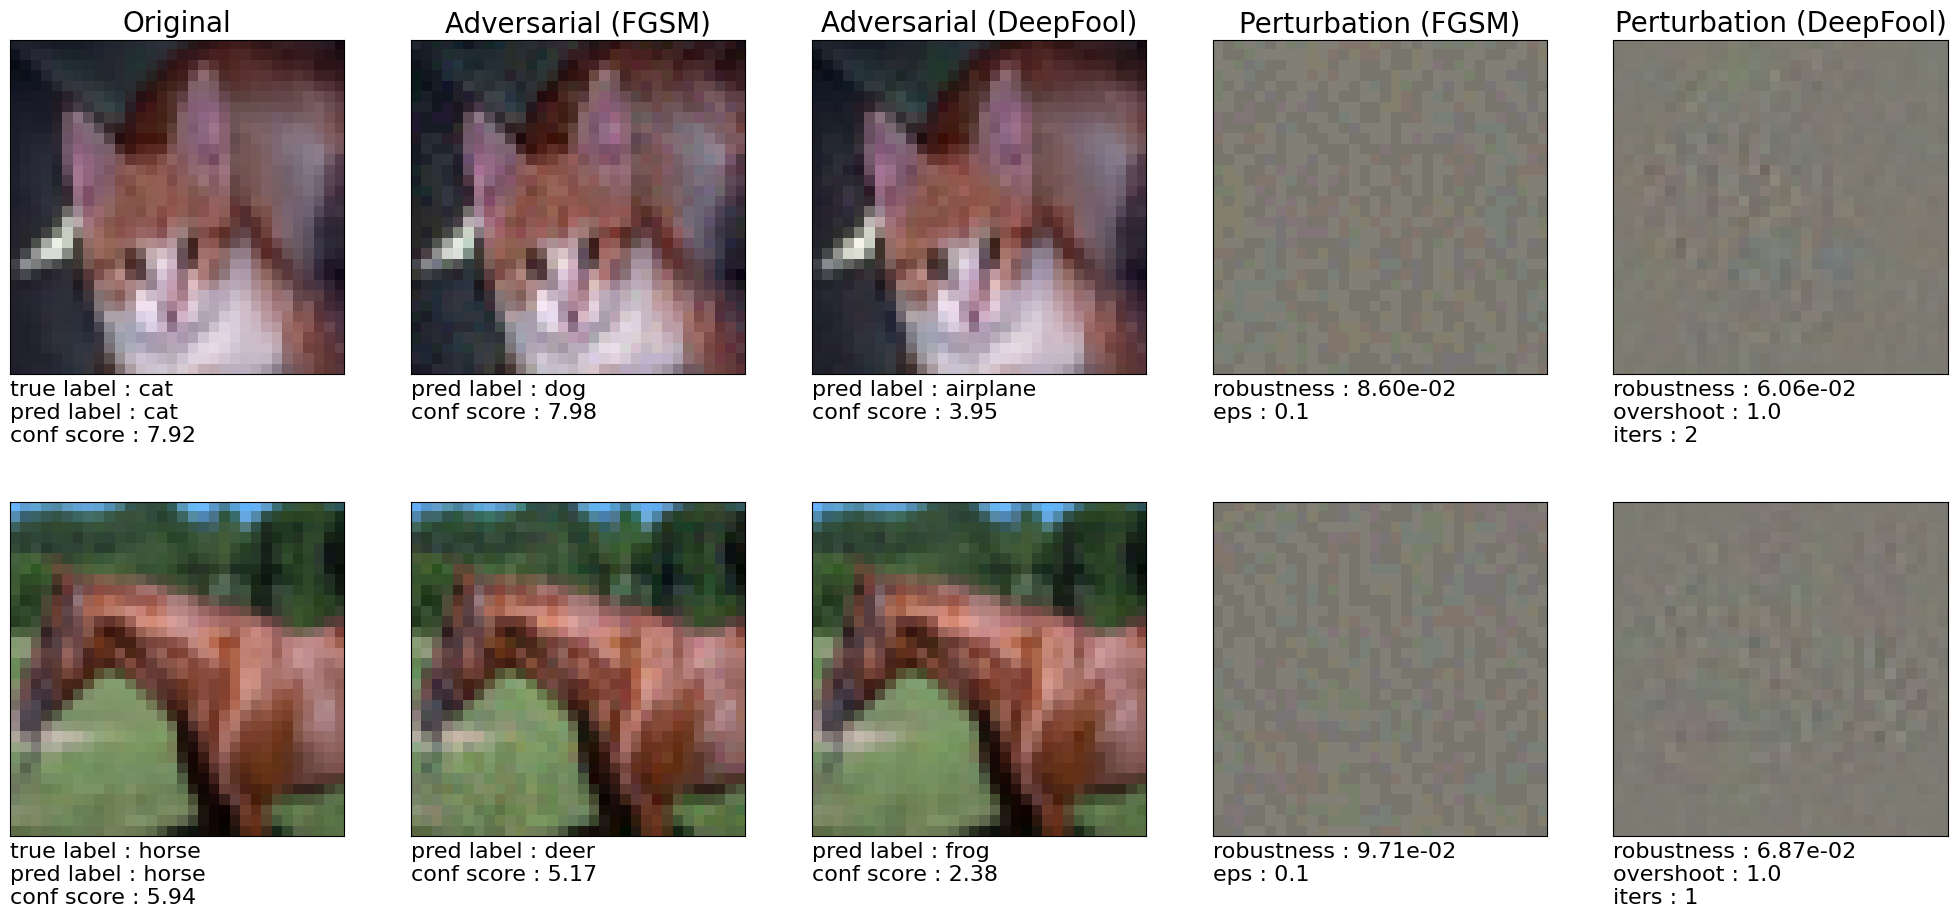

In [22]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(
    device,
    model,
    cifar_test,
    cifar_tf_inv,
    cifar_min,
    cifar_max,
    fgsm_eps,
    deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11,
    label_map=cifar_classes
)

if device.type == 'cuda':
    torch.cuda.empty_cache()


Вывод:

Проект направлен на оценку устойчивости нейронных сетей (LeNet, Network-in-Network, FCNet) к атакам FGSM и DeepFool. Исследования показали, что:

Устойчивость к атакам: Модели с более сложной архитектурой, такие как Network-in-Network, показали лучшую устойчивость на датасете CIFAR-10, в то время как LeNet оказалась более уязвимой, особенно при увеличении ε.
Параметр ε: Увеличение ε значительно снижает точность моделей, особенно для простых архитектур.
DeepFool генерирует минимальные искажения, что делает атаки труднее для обнаружения по сравнению с FGSM.
Для повышения устойчивости рекомендуется использовать более сложные модели и методы защиты, такие как adversarial training.
Проект подтверждает важность защиты от атак и оптимизации параметров для повышения устойчивости моделей.







